In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import SpectralClustering
from sklearn.mixture import GaussianMixture

from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, silhouette_samples, pairwise_distances, davies_bouldin_score, calinski_harabasz_score

In [12]:
wine = load_wine()
df = pd.DataFrame(wine.data, columns=wine.feature_names)

In [13]:
df.sample(3)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
51,13.83,1.65,2.60,17.2,94.0,2.45,2.99,0.22,2.29,5.60,1.24,3.37,1265.0
124,11.87,4.31,2.39,21.0,82.0,2.86,3.03,0.21,2.91,2.80,0.75,3.64,380.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0


In [14]:
X = StandardScaler().fit_transform(df)

n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X)

# Silhouette

In [15]:
def silhouette_knifes(X: np.ndarray, cluster_labels: np.ndarray):
    """
    Візуалізація "силуетного аналізу" (Silhouette Analysis) для кластеризації.

    Цей метод дозволяє оцінити якість кластеризації, показуючи,
    наскільки добре кожна точка відноситься до свого кластера
    у порівнянні з найближчим сусіднім кластером.

    ---
    Як працює:
    1. Для кожної точки обчислюється silhouette score (від -1 до 1):
       - значення близькі до 1 означають, що точка добре належить своєму кластеру;
       - значення близькі до 0 означають, що точка знаходиться на межі між кластерами;
       - значення менші за 0 означають, що точка "неправильно" класифікована
         (ближче до іншого кластера).
    2. Для кожного кластера будуються "смуги" з цих значень, відсортовані по величині.
    3. Червона вертикальна лінія показує середнє значення silhouette score
       для всієї кластеризації.

    ---
    Аргументи:
    :param X: np.ndarray
        Дані (матриця ознак), на яких проводилась кластеризація.
        Кожен рядок – це об'єкт, кожен стовпець – ознака.
    :param cluster_labels: np.ndarray
        Масив міток кластерів для кожної точки (наприклад, результат роботи
        KMeans, AgglomerativeClustering, DBSCAN тощо).

    ---
    Вихід:
    - Графік, де кожна кольорова "смуга" відповідає одному кластеру
      і показує розподіл silhouette score точок цього кластера.
    - Вертикальна червона пунктирна лінія показує середній silhouette score.

    ---
    Для чого потрібно:
    - Візуально оцінити, наскільки кластери чітко відділені.
    - Перевірити, чи є кластери з низькими silhouette score (погано відділені).
    - Порівнювати різні алгоритми або кількість кластерів і вибрати найкращий варіант.
    """
    
    n_clusters = len(np.unique(cluster_labels))
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(7, 4)

    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        cluster_colors = sns.color_palette("Set1", n_colors=n_clusters)
        color = cluster_colors[i % n_clusters]

        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10

    ax1.set_title(f"Silhouette plot for n_clusters = {n_clusters}")
    ax1.set_xlabel("Silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_score(X, cluster_labels), color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.show()

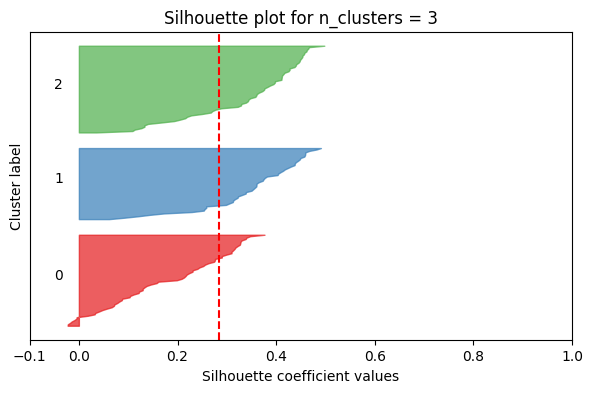

In [16]:
silhouette_knifes(X, cluster_labels)

# DBI

In [17]:
def dbi_matrix(X: np.ndarray, cluster_labels: np.ndarray):
    """
    Побудова матриці відстаней між центроїдами кластерів 
    з відображенням індексу Девіса–Булдіна (Davies–Bouldin Index, DBI).

    Навіщо:
    ----------------
    Індекс Девіса–Булдіна (DBI) — це метрика якості кластеризації, яка 
    вимірює, наскільки кластери "схожі" між собою. 
    Він враховує співвідношення:
        - внутрішньої компактності кластерів (наскільки щільно згруповані точки),
        - міжкластерних відстаней (наскільки далеко один кластер від іншого).

    Інтуїтивно:
        - Малий DBI → кластери добре відокремлені й компактні.
        - Великий DBI → кластери розмиті або перекриваються.

    Аргументи:
    ----------------
    X : np.ndarray, форма (n_samples, n_features)
        Дані для кластеризації, де кожен рядок — це об’єкт, а стовпці — ознаки.

    cluster_labels : np.ndarray, форма (n_samples,)
        Мітки кластерів, отримані після кластеризації. 
        Наприклад, результат `model.labels_`.

    Вихід:
    ----------------
    Побудований heatmap:
        - Вісь X і Y: номери кластерів.
        - Клітинки: відстань між центроїдами кластерів.
        - У заголовку: значення DBI для поточного розбиття.

    Інтерпретація:
    ----------------
    - Високі значення у матриці → кластери далеко один від одного (краще).
    - Низькі значення у матриці → кластери близько, можуть накладатися.
    - DBI у заголовку допомагає зрозуміти загальну якість: менше = краще.
    """

    clusters = np.unique(cluster_labels)
    centroids = np.array([X[cluster_labels == k].mean(axis=0) for k in clusters])
    dists = pairwise_distances(centroids)

    plt.figure(figsize=(6, 5))
    sns.heatmap(dists, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=clusters, yticklabels=clusters)
    plt.title(f"Centroid distances (DBI={davies_bouldin_score(X, cluster_labels):.3f})")
    plt.show()


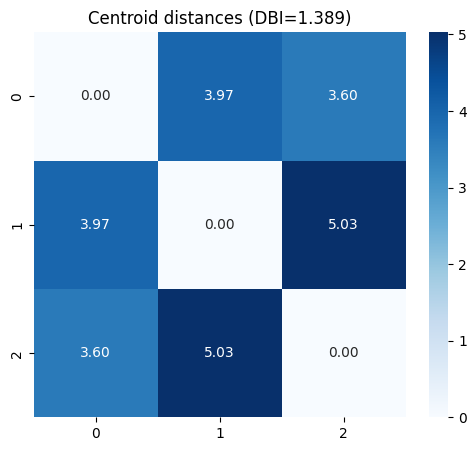

In [18]:
dbi_matrix(X, cluster_labels)

In [ ]:
def evaluate_clustering(X, labels, model_name):
    """
    • **Silhouette Score**:
        - Діапазон від -1 до 1.
        - Чим ближче до 1 → тим краще точки відповідають своїм кластерам.
        - Близько 0 → точки на межі кластерів.
        - Менше 0 → точки віднесені до неправильного кластера.
    • **Davies-Bouldin Index (DBI)**:
        - Чим менше значення → тим краще (кластери відділені чітко).
        - Базується на відношенні відстані між центрами кластерів до їх розкиду.
    • **Calinski-Harabasz Index (CHI)**:
        - Чим більше значення → тим краще.
        - Оцінює співвідношення між розсіюванням точок усередині кластерів і між кластерами.
    """
    
    if len(set(labels)) <= 1:
        print(f"{model_name}: кластеризація неуспішна (всього кластерів={len(set(labels))})")
        return

    sil = silhouette_score(X, labels)
    dbi = davies_bouldin_score(X, labels)
    chi = calinski_harabasz_score(X, labels)
    print(f"{model_name}:\n"
          f"  Silhouette: {sil:.3f}\n"
          f"  Davies-Bouldin: {dbi:.3f}\n"
          f"  Calinski-Harabasz: {chi:.3f}")

# KMeans

Що таке KMeans:

KMeans — класичний алгоритм кластеризації, який намагається розбити дані на k кластерів, мінімізуючи суму квадратів відстаней точок до центру їх кластеру (середнього).
Алгоритм належить до жорстких кластеризацій (hard clustering) — кожна точка належить лише до одного кластера.

Як працює KMeans:

Вибираються k початкових центроїдів (можна випадково або через k-means++).
Кожна точка призначається до найближчого центру (кластеру).
Центроїди оновлюються як середнє всіх точок у кластері.
Кроки 2–3 повторюються до збіжності (поки центроїди не змінюються або зміни мінімальні).

Коли використовувати KMeans:

Дані мають сферичну або кулясту структуру кластерів.
Коли важлива швидка кластеризація великих наборів даних.
Якщо потрібні жорсткі кластерні мітки для подальшого аналізу або моделей.

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=42).fit(X)
evaluate_clustering(X, kmeans.labels_, "KMeans")

KMeans:
  Silhouette: 0.285
  Davies-Bouldin: 1.389
  Calinski-Harabasz: 70.940


# GaussianMixture

Що таке GaussianMixture (GMM):

Це алгоритм кластеризації на основі імовірнісної моделі.
Кожен кластер моделюється як мультиваріантний нормальний розподіл (Gaussian).
Алгоритм намагається підібрати параметри цих розподілів (середнє, ковариацію, вагу) так, щоб максимально наблизити їх до даних.
Кластеризація відбувається через ймовірнісне віднесення кожної точки до кластерів (soft clustering) або через predict() для жорсткого присвоєння (hard clustering).

Як працює GMM:

Ініціалізуються параметри компонентів (середнє, ковариація, ваги).
Виконується Expectation-Maximization (EM) алгоритм:
E-step: обчислюємо ймовірність, що кожна точка належить до кожного кластера.
M-step: оновлюємо параметри Gaussian-компонентів, щоб максимізувати ймовірність даних.
Повторюється до збіжності (поки зміни параметрів не стануть малими).

Коли використовувати GMM:

Коли кластери мають еліптичну форму (не обов’язково сферичні, як у KMeans).
Коли потрібен soft clustering — точки можуть належати кільком кластерам з певними ймовірностями.
Коли дані можуть бути представлені як суміш нормальних розподілів.

In [ ]:
gmm = GaussianMixture(n_components=3, random_state=42).fit(X)
evaluate_clustering(X, gmm.predict(X), "GaussianMixture")

GaussianMixture:
  Silhouette: 0.285
  Davies-Bouldin: 1.389
  Calinski-Harabasz: 70.940


# AgglomerativeClustering

Що таке AgglomerativeClustering:

Це алгоритм ієрархічної кластеризації (bottom-up).
Ідея: починаємо з того, що кожна точка – окремий кластер, і поступово з’єднуємо найближчі кластери до тих пір, поки не отримаємо потрібну кількість n_clusters.
В результаті виходить дерево кластерів (дендрограма), з якого можна обрати будь-яку глибину розбиття.

Як працює:

Кожна точка спочатку окремий кластер.
Обчислюється відстань між усіма кластерами.
Найближчі кластери об’єднуються в один.
Кроки 2–3 повторюються, доки не залишиться n_clusters.
Види з’єднання (linkage):
ward – мінімізує суму квадратів відстаней всередині кластерів.
complete – відстань між найбільш віддаленими точками.
average – середня відстань між точками кластера.
single – відстань між найближчими точками (може створювати "ланцюжки").

Коли використовувати:

Коли цікава ієрархічна структура даних.
Коли кластери можуть мати необов’язково сферичну форму.
Для середніх і невеликих наборів даних (великий n_samples → висока складність).

In [ ]:
agg = AgglomerativeClustering(n_clusters=3).fit(X)
evaluate_clustering(X, agg.labels_, "AgglomerativeClustering")

AgglomerativeClustering:
  Silhouette: 0.277
  Davies-Bouldin: 1.419
  Calinski-Harabasz: 67.647


# SpectralClustering

Що таке SpectralClustering:

Це алгоритм кластеризації, який працює через спектральний аналіз графа схожості точок.

Ідея: побудувати граф, де вузли — це точки даних, а ребра відображають близькість (affinity) між ними.
    Потім обчислюються власні вектори матриці Лапласа цього графа (спектральний аналіз), і кластери визначаються на основі цих векторів (звичайно через KMeans у зниженому просторі).

Як працює affinity='nearest_neighbors':

Замість повної матриці відстаней алгоритм підключає тільки k найближчих сусідів для кожної точки.
Це допомагає уникнути шуму у великих або розріджених даних.
Можна також використовувати 'rbf' (Gaussian kernel) для згладжування відстаней.

Коли використовувати SpectralClustering:

Коли кластери мають складну форму (не сферичні) і традиційний KMeans не справляється.
Коли потрібна кластеризація на основі графової структури.
Для даних з чіткими локальними сусідніми зв’язками (наприклад, точки на петлях або кільцях).

In [ ]:
spec = SpectralClustering(n_clusters=3, random_state=42, affinity='nearest_neighbors').fit(X)
evaluate_clustering(X, spec.labels_, "SpectralClustering")

SpectralClustering:
  Silhouette: 0.283
  Davies-Bouldin: 1.391
  Calinski-Harabasz: 70.041


# DBSCAN

Що таке DBSCAN:

DBSCAN — це щільнісний алгоритм кластеризації, який виділяє кластери на основі щільності точок, а не на основі центроїдів або ймовірнісних моделей.
Алгоритм визначає три типи точок:
Core points — точки з достатньою кількістю сусідів у радіусі eps.
Border points — точки, які лежать у межах eps від core-пунктів, але самі не є core.
Noise points (шум) — точки, які не належать ні до одного кластера.

Як працює:

Для кожної точки визначаємо сусідів у радіусі eps.
Якщо точка має ≥ min_samples сусідів → вона core.
Кластери формуються шляхом об’єднання всіх core-т точок та їх border-т точок.
Точки, які не потрапили ні в один кластер, позначаються як шум (label = -1).
Параметри:
eps: максимальна відстань для того, щоб вважати точки сусідами.
min_samples: мінімальна кількість точок у eps-околі, щоб створити core-point.

Коли використовувати DBSCAN:

Кластери можуть мати будь-яку форму (не обов’язково сферичні).
Є присутній шум у даних — DBSCAN автоматично виділяє його.
Класичний KMeans або GaussianMixture не підходять для сильно нерегулярних кластерів.

In [ ]:
db = DBSCAN(eps=0.5, min_samples=5).fit(X)
evaluate_clustering(X, db.labels_, "DBSCAN")

DBSCAN: кластеризація неуспішна (всього кластерів=1)
